In [1]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler
%env PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:256

env: PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:256


In [2]:
import copy
import cProfile
import time

import ase.io
import matplotlib.pyplot as plt
import numpy as np
import sklearn.model_selection
import torch

from utils.combine import CombineRadial, CombineRadialSpecies, CombineSpecies
from utils.dataset import AtomisticDataset, create_dataloader
from utils.linear import LinearModel
from utils.operations import SumStructures, remove_gradient
from utils.soap import PowerSpectrum, CompositionFeatures

torch.set_default_dtype(torch.float64)

In [3]:
n_test = 10
n_train = 80
n_train_forces = 20

frames = ase.io.read("data/data_shuffle.xyz", f":{n_test + n_train + n_train_forces}")

train_frames = frames[:n_train]
train_forces_frames = frames[n_train:n_train+n_train_forces]
test_frames = frames[-n_test:]

train_energies = torch.tensor(
    [frame.info["energy"] for frame in train_frames]
).reshape(-1, 1).to(dtype=torch.get_default_dtype())

test_energies = torch.tensor(
    [frame.info["energy"] for frame in test_frames]
).reshape(-1, 1).to(dtype=torch.get_default_dtype())


train_forces_e = torch.tensor(
    [frame.info["energy"] for frame in train_forces_frames]
).reshape(-1, 1).to(dtype=torch.get_default_dtype())

train_forces_f = [
    torch.tensor(frame.arrays["forces"]).to(dtype=torch.get_default_dtype())
    for frame in train_forces_frames
]

test_forces = [
    torch.tensor(frame.arrays["forces"]).to(dtype=torch.get_default_dtype()) 
    for frame in test_frames
]

print(f"using {n_train} training frames")

using 80 training frames


In [4]:
all_species = set()
for frame in frames:
    all_species.update(frame.numbers)

all_species = list(map(lambda u: int(u), all_species))

# HYPERS_FROM_PAPER = {
#     "interaction_cutoff": 5.0,
#     "max_angular": 9,
#     "max_radial": 12,
#     "gaussian_sigma_constant": 0.3,
#     "gaussian_sigma_type": "Constant",
#     "cutoff_smooth_width": 0.5,
#     "radial_basis": "GTO",
#     "compute_gradients": False,
#     "expansion_by_species_method": "user defined",
#     "global_species": all_species,
# }

HYPERS_SMALL = {
    "cutoff": 4.0,
    "max_angular": 3,
    "max_radial": 6,
    "atomic_gaussian_width": 0.5,
    "cutoff_function": {"ShiftedCosine": {"width": 0.5}},
    "radial_basis": {"SplinedGto": {"accuracy": 1e-6}},
    "gradients": False,
    "center_atom_weight": 1.0,
    "radial_scaling":  {"Willatt2018": { "scale": 2.5, "rate": 0.8, "exponent": 2}}
    # # TODO: implement this in rascaline itself
    # "radial_per_angular": {
    #     # l: n
    #     0: 10,
    #     1: 8,
    #     2: 8,
    #     3: 4,
    #     4: 4,
    # }
}

HYPERS_RADIAL = {
    "cutoff": 5.0,
    "max_angular": 0,
    "max_radial": 10,
    "atomic_gaussian_width": 0.5,
    "cutoff_function": {"ShiftedCosine": {"width": 0.5}},
    "radial_basis": {"SplinedGto": {"accuracy": 1e-6}},
    "gradients": False,
    "center_atom_weight": 1.0,    
    "radial_scaling":  {"Willatt2018": { "scale": 2.5, "rate": 0.8, "exponent": 2}}
}

# Optimization loop, energies only

In [5]:
device = "cpu"

#if torch.cuda.is_available():
#    device = "cuda"

In [6]:
train_dataset = AtomisticDataset(train_frames, all_species, 
                                 {"radial_spectrum": HYPERS_RADIAL, "spherical_expansion":HYPERS_SMALL}, train_energies)
train_forces_dataset = AtomisticDataset(train_forces_frames, all_species, 
                                 {"radial_spectrum": HYPERS_RADIAL, "spherical_expansion":HYPERS_SMALL}, train_forces_e)
test_dataset = AtomisticDataset(test_frames, all_species, 
                                {"radial_spectrum": HYPERS_RADIAL, "spherical_expansion":HYPERS_SMALL}, test_energies)

In [7]:
do_gradients = True
if do_gradients is True:
    HYPERS_GRAD = copy.deepcopy(HYPERS_SMALL)
    HYPERS_GRAD["gradients"] = do_gradients
    HYPERS_RAD_GRAD = copy.deepcopy(HYPERS_RADIAL)
    HYPERS_RAD_GRAD["gradients"] = do_gradients
    train_forces_dataset_grad = AtomisticDataset(train_forces_frames, all_species, 
                                          {"radial_spectrum": HYPERS_RAD_GRAD, "spherical_expansion":HYPERS_GRAD}, 
                                          train_forces_e, train_forces_f)
    test_dataset_grad = AtomisticDataset(test_frames, all_species, 
                                         {"radial_spectrum": HYPERS_RAD_GRAD, "spherical_expansion":HYPERS_GRAD}, 
                                         test_energies, test_forces)
else:
    train_forces_dataset_grad = train_forces_dataset
    test_dataset_grad = test_dataset

In [8]:
train_dataloader = create_dataloader(
    train_dataset,
    batch_size=200,
    shuffle=True,    
    device=device,
)

train_forces_dataloader = create_dataloader(
    train_forces_dataset,
    batch_size=200,
    shuffle=True,    
    device=device,
)

train_dataloader_no_batch = create_dataloader(
    train_dataset,
    batch_size=len(train_dataset),
    shuffle=False,
    device=device,
)

train_forces_dataloader_no_batch = create_dataloader(
    train_forces_dataset,
    batch_size=len(train_dataset),
    shuffle=False,
    device=device,
)

train_forces_dataloader_single_frame = create_dataloader(
    train_forces_dataset,
    batch_size=1,
    shuffle=False,
    device=device,
)

test_dataloader = create_dataloader(
    test_dataset,
    batch_size=200,
    shuffle=False,
    device=device,
)

if do_gradients is True:
    train_forces_dataloader_grad = create_dataloader(
        train_forces_dataset_grad,
        batch_size=50,
        shuffle=True,
        device=device,
    )

    train_forces_dataloader_grad_single_frame = create_dataloader(
        train_forces_dataset_grad,
        batch_size=1,
        shuffle=True,
        device=device,
    )
    
    train_forces_dataloader_grad_no_batch = create_dataloader(
        train_forces_dataset_grad,
        batch_size=len(train_forces_dataset_grad),
        shuffle=False,
        device=device,
    )
    
    test_dataloader_grad = create_dataloader(
        test_dataset_grad,
        batch_size=50,
        shuffle=False,
        device=device,
    )
else:
    train_forces_dataloader_grad = train_forces_dataloader
    train_forces_dataloader_grad_single_frame = train_forces_dataloader_single_frame
    train_forces_dataloader_grad_no_batch = train_forces_dataloader_no_batch
    test_dataloader_grad = test_dataloader

In [9]:
def loss_mae(predicted, actual):
    return torch.sum(torch.abs(predicted.flatten() - actual.flatten()))

def loss_mse(predicted, actual):
    return torch.sum((predicted.flatten() - actual.flatten())**2)

def loss_rmse(predicted, actual):
    return np.sqrt(loss_mse(predicted, actual))

In [10]:
class CombinedPowerSpectrum(torch.nn.Module):
    def __init__(self, combiner):
        super().__init__()

        self.combiner = combiner
        self.power_spectrum = PowerSpectrum()

    def forward(self, spherical_expansion):
        combined = self.combiner(spherical_expansion)

        return self.power_spectrum(combined)

        
class MultiBodyOrderModel(torch.nn.Module):
    def __init__(
        self, 
        power_spectrum,
        composition_regularizer,
        radial_spectrum_regularizer,
        power_spectrum_regularizer,        
        optimizable_weights,
        random_initial_weights,
    ):
        super().__init__()

        self.sum_structure = SumStructures()

        # optimizable_weights = False is not very well tested ...
        assert optimizable_weights

        if composition_regularizer is None:
            self.composition_model = None
        else:
            self.composition_model=LinearModel(
            regularizer=composition_regularizer,
            optimizable_weights=optimizable_weights,
            random_initial_weights=random_initial_weights,
        )
        
        if radial_spectrum_regularizer is None:
            self.radial_spectrum_model = None
        else:
            self.radial_spectrum_model = LinearModel(
                regularizer=radial_spectrum_regularizer,
                optimizable_weights=optimizable_weights,
                random_initial_weights=random_initial_weights,
            )

        if power_spectrum_regularizer is None:
            self.power_spectrum_model = None
        else:
            self.power_spectrum = power_spectrum
            self.power_spectrum_model = LinearModel(
                regularizer=power_spectrum_regularizer,
                optimizable_weights=optimizable_weights,
                random_initial_weights=random_initial_weights,
            )

        self.combiner = combiner, 
        self.optimizable_weights = optimizable_weights
        self.random_initial_weights = random_initial_weights

    def forward(self, composition, radial_spectrum, spherical_expansion, forward_forces=False):
        if not forward_forces:
            # remove gradients if we don't need them
            spherical_expansion = remove_gradient(spherical_expansion)
            if radial_spectrum is not None:
                radial_spectrum = remove_gradient(radial_spectrum)                
    
        energies, forces = None, None
        
        if self.composition_model is not None:
            energies_cmp, _ = self.composition_model(composition)
            energies = energies_cmp
            forces = None
    
        if self.radial_spectrum_model is not None:
            radial_spectrum_per_structure = radial_spectrum #self.sum_structure(radial_spectrum)
            energies_rs, forces_rs = self.radial_spectrum_model(radial_spectrum_per_structure, with_forces=forward_forces)
            
            if energies is None:
                energies = energies_rs  
            else:
                energies += energies_rs              
            if forces_rs is not None:
                if forces is None:
                    forces = forces_rs
                else:
                    forces += forces_rs

        if self.power_spectrum_model is not None:
            power_spectrum = self.power_spectrum(spherical_expansion)
            power_spectrum_per_structure = self.sum_structure(power_spectrum)

            energies_ps, forces_ps = self.power_spectrum_model(power_spectrum_per_structure, with_forces=forward_forces)
            if energies is None:
                energies = energies_ps
            else:
                energies += energies_ps
            if forces_ps is not None:
                if forces is None:
                    forces = forces_ps
                else:
                    forces += forces_ps
        
        return energies, forces

    def initialize_model_weights(self, composition, radial_spectrum, spherical_expansion, energies, forces=None, seed=None):
        if forces is None:
            # remove gradients if we don't need them
            spherical_expansion = remove_gradient(spherical_expansion)
            if radial_spectrum is not None:
                radial_spectrum = remove_gradient(radial_spectrum)
            
        if self.composition_model is not None:
            self.composition_model.initialize_model_weights(composition, energies, forces, seed)
        
        if self.radial_spectrum_model is not None:
            radial_spectrum_per_structure = self.sum_structure(radial_spectrum)
            self.radial_spectrum_model.initialize_model_weights(radial_spectrum_per_structure, energies, forces, seed)
        
        if self.power_spectrum_model is not None:        
            power_spectrum = self.power_spectrum(spherical_expansion)
            power_spectrum_per_structure = self.sum_structure(power_spectrum)
            self.power_spectrum_model.initialize_model_weights(power_spectrum_per_structure, energies, forces, seed)

In [11]:
# species combination only
N_PSEUDO_SPECIES = 4
combiner = CombineSpecies(species=all_species, n_pseudo_species=N_PSEUDO_SPECIES)

# # species combination and then radial basis combination
# N_COMBINED_RADIAL = 4
# combiner = torch.nn.Sequential(
#     CombineSpecies(species=all_species, n_pseudo_species=N_PSEUDO_SPECIES),
#     CombineRadial(max_radial=HYPERS_SMALL["max_radial"], n_combined_radial=N_COMBINED_RADIAL),
# )

# # combine both radial and species information at the same time
# combiner = CombineRadialSpecies(
#     n_species=len(all_species), 
#     max_radial=HYPERS_SMALL["max_radial"], 
#     n_combined_basis=N_COMBINED_RADIAL*N_PSEUDO_SPECIES,
# )

composition=CompositionFeatures(all_species, device=device)
power_spectrum = CombinedPowerSpectrum(combiner)

LINALG_REGULARIZER_ENERGIES = 1e-2
LINALG_REGULARIZER_FORCES = 1e-1

model = MultiBodyOrderModel(
    power_spectrum=power_spectrum, 
    composition_regularizer=[1e-10],
    radial_spectrum_regularizer=[LINALG_REGULARIZER_ENERGIES, LINALG_REGULARIZER_FORCES],
    power_spectrum_regularizer=[LINALG_REGULARIZER_ENERGIES, LINALG_REGULARIZER_FORCES],
    optimizable_weights=True, 
    random_initial_weights=True,
)

In [12]:
if model.optimizable_weights:
    TORCH_REGULARIZER_COMPOSITION = 1e-8
    TORCH_REGULARIZER_RADIAL_SPECTRUM = 1e-4
    TORCH_REGULARIZER_POWER_SPECTRUM = 1e-3
else:
    TORCH_REGULARIZER_RADIAL_SPECTRUM = 0.0
    TORCH_REGULARIZER_POWER_SPECTRUM = 0.0

In [13]:
model.to(device=device, dtype=torch.get_default_dtype())

MultiBodyOrderModel(
  (sum_structure): SumStructures()
  (composition_model): LinearModel()
  (radial_spectrum_model): LinearModel()
  (power_spectrum): CombinedPowerSpectrum(
    (combiner): CombineSpecies()
    (power_spectrum): PowerSpectrum()
  )
  (power_spectrum_model): LinearModel()
)

In [14]:
if model.random_initial_weights:
    dataloader_initialization = train_forces_dataloader_grad_single_frame
else:
    dataloader_initialization = train_dataloader_no_batch

In [15]:
# initialize the model
with torch.no_grad():
    for composition, radial_spectrum, spherical_expansions, energies, forces in dataloader_initialization:
        # we want to intially train the model on all frames, to ensure the
        # support points come from the full dataset.
        model.initialize_model_weights(composition, radial_spectrum, spherical_expansions, energies, forces, seed=12345)
        break

del radial_spectrum, spherical_expansions

In [16]:
lr = 0.2
# optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.0)
optimizer = torch.optim.LBFGS(model.parameters(), lr=lr, line_search_fn="strong_wolfe", history_size=128)

In [17]:
lr = 0.1
# optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.0)
optimizer = torch.optim.LBFGS(model.parameters(), lr=lr)#, line_search_fn="strong_wolfe", history_size=128)

all_losses = []
all_tests=[]
f_all_tests=[]

filename = f"{model.__class__.__name__}-{N_PSEUDO_SPECIES}-mixed-{n_train}-train"
if model.optimizable_weights:
    filename += "-opt-weights"

if model.random_initial_weights:
    filename += "-random-weights"

output = open(f"{filename}.dat", "w")
output.write("# epoch  train_loss  test_mae\n")
n_epochs_total = 0

In [18]:
sum(p.detach().cpu().numpy().nbytes for p in model.parameters())
train_dataset._collatetime = 0

In [19]:
assert model.optimizable_weights
himem = True
if himem and len(all_losses)==0:
    composition, radial_spectrum, spherical_expansions, energies, forces = next(iter(train_dataloader_no_batch))
    f_composition, f_radial_spectrum, f_spherical_expansions, f_energies, f_forces = next(iter(train_forces_dataloader_grad_no_batch))

In [29]:
for epoch in range(10):
    epoch_start = time.time()

    def single_step():
        global composition, radial_spectrum, spherical_expansions, energies
        optimizer.zero_grad()
        if device=="cuda":
            print(f"mem. before:  {torch.cuda.memory_stats()['allocated_bytes.all.current']/1e6} MB allocated, {torch.cuda.memory_stats()['reserved_bytes.all.current']/1e6} MB reserved ")
        loss = torch.zeros(size=(1,), device=device)
        loss_force = torch.zeros(size=(1,), device=device)
        if himem:
            predicted, _ = model(composition, radial_spectrum, spherical_expansions, forward_forces=False)
            loss += loss_mse(predicted, energies)
            f_predicted_e, f_predicted_f = model(f_composition, f_radial_spectrum, f_spherical_expansions, forward_forces=do_gradients)
            loss += loss_mse(f_predicted_e, f_energies)
            if do_gradients:
                loss_force += loss_mse(f_predicted_f, f_forces)/42
        else:
            for composition, radial_spectrum, spherical_expansions, energies, forces in train_dataloader:
                try:
                    predicted, _ = model(composition, radial_spectrum, spherical_expansions, forward_forces=False)
                except:
                    if device=="cuda":
                        print(f"mem. during:  {torch.cuda.memory_stats()['allocated_bytes.all.current']/1e6} MB allocated, {torch.cuda.memory_stats()['reserved_bytes.all.current']/1e6} MB reserved ")
                    raise
                loss += loss_mse(predicted, energies)
            raise ValueError("MUST IMPLEMENT FORCE CALCULATOR FOR THIS PATH!")
        loss /= n_train
        if model.composition_model is not None:
            loss += TORCH_REGULARIZER_COMPOSITION * torch.linalg.norm(model.composition_model.weights)
        if model.radial_spectrum_model is not None:
            loss += TORCH_REGULARIZER_RADIAL_SPECTRUM * torch.linalg.norm(model.radial_spectrum_model.weights)
        if model.power_spectrum_model is not None:
            loss += TORCH_REGULARIZER_POWER_SPECTRUM * torch.linalg.norm(model.power_spectrum_model.weights)

        print(f"Train loss: {(loss+loss_force).item()} E={loss.item()}, F={loss_force.item()}")
        loss+=loss_force
        loss.backward(retain_graph=False)
        print("Loss gradient", np.linalg.norm(model.composition_model.weights.grad.numpy()))
        return loss
            
    loss = optimizer.step(single_step)
    loss = loss.item()
    all_losses.append(loss)

    epoch_time = time.time() - epoch_start
    if epoch % 1 == 0:
        print("norms", np.linalg.norm(0 if model.composition_model is None else model.composition_model.weights.detach().cpu().numpy()),
                  np.linalg.norm(0 if model.radial_spectrum_model is None else model.radial_spectrum_model.weights.detach().cpu().numpy()),
                  np.linalg.norm(0 if model.power_spectrum_model is None else model.power_spectrum_model.weights.detach().cpu().numpy())
                 )
        print("gradients", 
                  np.linalg.norm(0 if model.composition_model is None else model.composition_model.weights.grad.detach().cpu().numpy()),
                  np.linalg.norm(0 if model.radial_spectrum_model is None else model.radial_spectrum_model.weights.grad.detach().cpu().numpy()),
                  np.linalg.norm(0 if model.power_spectrum_model is None else model.power_spectrum_model.weights.grad.detach().cpu().numpy())
                 )
        with torch.no_grad():
            predicted = []
            reference = []
            f_predicted = []
            f_reference = []
            for tcomposition, tradial_spectrum, tspherical_expansions, tenergies, tforces in test_dataloader_grad:
                reference.append(tenergies)
                tpredicted_e, tpredicted_f = model(tcomposition, tradial_spectrum, tspherical_expansions, forward_forces=do_gradients)
                predicted.append(tpredicted_e)                
                if do_gradients:
                    f_predicted.append(tpredicted_f)
                    f_reference.append(tforces)

            reference = torch.vstack(reference)
            predicted = torch.vstack(predicted)
            test_mae = loss_mae(predicted, reference)/n_test
            output.write(f"{n_epochs_total} {loss} {test_mae}")
            if do_gradients:
                f_reference = torch.vstack(f_reference)
                f_predicted = torch.vstack(f_predicted)
                f_test_mae = loss_mae(f_predicted, f_reference)/n_test/42
                output.write(f"{f_test_mae}")                
            output.write("\n")
            output.flush()
        all_tests.append(test_mae.item())
        f_all_tests.append(f_test_mae.item())
        print(f"epoch {n_epochs_total} took {epoch_time:.4}s, optimizer loss={loss:.4}, test mae={test_mae:.4}"+
              (f" test mae force={f_test_mae:.4}"))
    
    del loss
    n_epochs_total += 1

Train loss: 23.01081143016268 E=2.5124448232771077, F=20.498366606885572
Loss gradient 1.943185493867989
Train loss: 22.805763795357375 E=2.4484713521838217, F=20.357292443173552
Loss gradient 1.7541135305835343
Train loss: 22.61066281556637 E=2.3925311298974283, F=20.218131685668943
Loss gradient 1.7788643164209652
Train loss: 22.410199972599706 E=2.3331694419121534, F=20.07703053068755
Loss gradient 1.6687747747809922
Train loss: 22.244074350103908 E=2.2884067131542447, F=19.955667636949663
Loss gradient 1.6421808705240342
Train loss: 22.07488212451543 E=2.2418471651417335, F=19.833034959373695
Loss gradient 1.5489261318807643
Train loss: 21.912460933485107 E=2.2040742648099756, F=19.708386668675132
Loss gradient 1.506729870047192
Train loss: 21.747849402846914 E=2.169406512836034, F=19.57844289001088
Loss gradient 1.6591445601084056
Train loss: 21.61154709745433 E=2.143408015639736, F=19.468139081814595
Loss gradient 1.673506759498311
Train loss: 21.45461363357821 E=2.11975921112234

Loss gradient 1.0188248693192241
Train loss: 14.651551239734761 E=1.4950163974477484, F=13.156534842287012
Loss gradient 1.065428411535676
Train loss: 14.571579447278161 E=1.4910157230037857, F=13.080563724274375
Loss gradient 1.0045262100294519
Train loss: 14.503645933806286 E=1.4883364745438186, F=13.015309459262468
Loss gradient 0.9983064124477253
Train loss: 14.433836707112398 E=1.4837669238845717, F=12.950069783227827
Loss gradient 1.0003634417791236
Train loss: 14.359183197868774 E=1.482842830016536, F=12.876340367852238
Loss gradient 1.004524456438762
Train loss: 14.286578305107911 E=1.478062913327017, F=12.808515391780894
Loss gradient 0.9722095722668341
Train loss: 14.214565263824174 E=1.476978318045831, F=12.737586945778343
Loss gradient 1.0084661816995921
Train loss: 14.14744794657646 E=1.4736364029243894, F=12.67381154365207
Loss gradient 0.9704488382772841
norms 28.14327868047548 43.564087156308865 29.298831419207282
gradients 0.9704488382772841 1.9364293016561125 2.094417

Train loss: 10.865867212245814 E=0.6766119057629989, F=10.189255306482815
Loss gradient 0.7018342814151376
Train loss: 10.832178133216441 E=0.6756436564401942, F=10.156534476776248
Loss gradient 0.7029095853890883
Train loss: 10.798695177956283 E=0.6754244836817056, F=10.123270694274577
Loss gradient 0.6598036575465922
Train loss: 10.764369496112902 E=0.6760269643046863, F=10.088342531808216
Loss gradient 0.7398879973768058
Train loss: 10.734495527577321 E=0.6776688990430959, F=10.056826628534225
Loss gradient 0.6786906826455819
Train loss: 10.706952781394305 E=0.6787986877991723, F=10.028154093595132
Loss gradient 0.7369867219058568
Train loss: 10.679968440628375 E=0.6807260862668645, F=9.999242354361511
Loss gradient 0.6953394942438558
Train loss: 10.652835128923401 E=0.6819465151623209, F=9.97088861376108
Loss gradient 0.7689253927975883
Train loss: 10.626687847063259 E=0.6838534345114171, F=9.942834412551841
Loss gradient 0.7272568522333175
Train loss: 10.601068089183565 E=0.685064

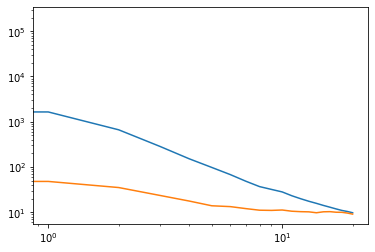

In [30]:
plt.loglog(all_losses)
plt.loglog(all_tests)

In [20]:
train_dataset._getitemtime

0

In [21]:
train_dataset._collatetime

0

TEST MAE: 0.25125926946103255 eV/at


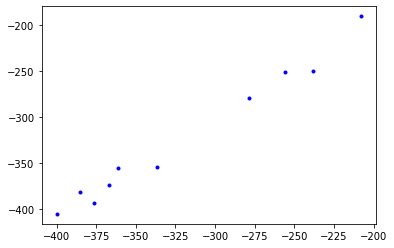

In [31]:
plt.plot(predicted.numpy(), reference.numpy(), 'b.')
print(f"TEST MAE: {test_mae.item()/len(frames[0])} eV/at")

TEST MAE: 1.294715541507307 eV/A


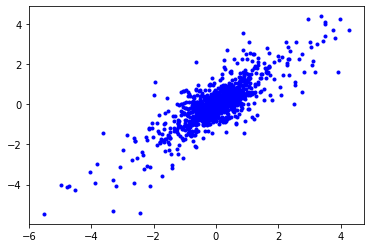

In [32]:
plt.plot(f_predicted.numpy(), f_reference.numpy(), 'b.')
print(f"TEST MAE: {f_test_mae.item()} eV/A")

In [26]:
with torch.no_grad():
    tpredicted = []
    treference = []
    for tcomposition, tradial_spectrum, tspherical_expansions, tenergies, _ in train_dataloader:
        treference.append(tenergies)
        predicted_e, _ = model(tcomposition, tradial_spectrum, tspherical_expansions, forward_forces=False)
        tpredicted.append(predicted_e)

    treference = torch.vstack(treference)
    tpredicted = torch.vstack(tpredicted)
    tmae = loss_mae(tpredicted, treference)/n_train

TRAIN MAE: 0.0799058042631911 eV/at


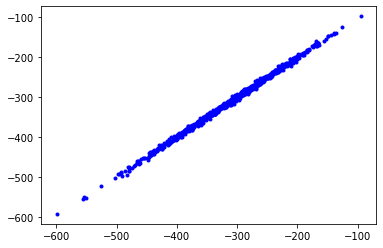

In [27]:
plt.plot(tpredicted, treference, 'b.')
print(f"TRAIN MAE: {tmae.item()/len(frames[0])} eV/at")

# Predicting forces with forward propagation

In [25]:
def evaluate_model_with_forces(model, dataloader):
    predicted_e = []
    reference_e = []
    predicted_f = []
    reference_f = []
    for composition, radial_spectrum, spherical_expansions, energies, forces in dataloader:
        reference_e.append(energies)
        reference_f.append(forces)
        e, f = model(composition, radial_spectrum, spherical_expansions, forward_forces=True)
        predicted_e.append(e)
        predicted_f.append(f)

    reference_e = torch.vstack(reference_e)
    predicted_e = torch.vstack(predicted_e)

    reference_f = torch.vstack(reference_f)
    predicted_f = torch.vstack(predicted_f)

    return reference_e, predicted_e, reference_f, predicted_f

In [26]:
def parity_plots(reference_e, predicted_e, reference_f, predicted_f):
    predicted_e = predicted_e.detach()
    predicted_f = predicted_f.detach()

    fig, (ax_e, ax_f) = plt.subplots(1, 2, figsize=(16, 8))

    mae = loss_mae(predicted_e, reference_e)
    rmse = loss_rmse(predicted_e, reference_e)
    ax_e.scatter(reference_e.cpu(), predicted_e.cpu())
    x = (torch.min(reference_e.flatten()).item(), torch.max(reference_e.flatten()).item())
    ax_e.plot(x, x, color="red")
    ax_e.set_title(f"energies, MAE={mae:.4}, RMSE={rmse:.4}")
    ax_e.set_xlabel("actual")
    ax_e.set_ylabel("predicted")

    mae = loss_mae(predicted_f, reference_f)
    rmse = loss_rmse(predicted_f, reference_f)
    ax_f.scatter(reference_f.cpu(), predicted_f.cpu())
    x = (torch.min(reference_f.flatten()).item(), torch.max(reference_f.flatten()).item())
    ax_f.plot(x, x, color="red")
    ax_f.set_title(f"forces, MAE={mae:.4}, RMSE={rmse:.4}")
    ax_f.set_xlabel("actual")
    ax_f.set_ylabel("predicted")

    return fig

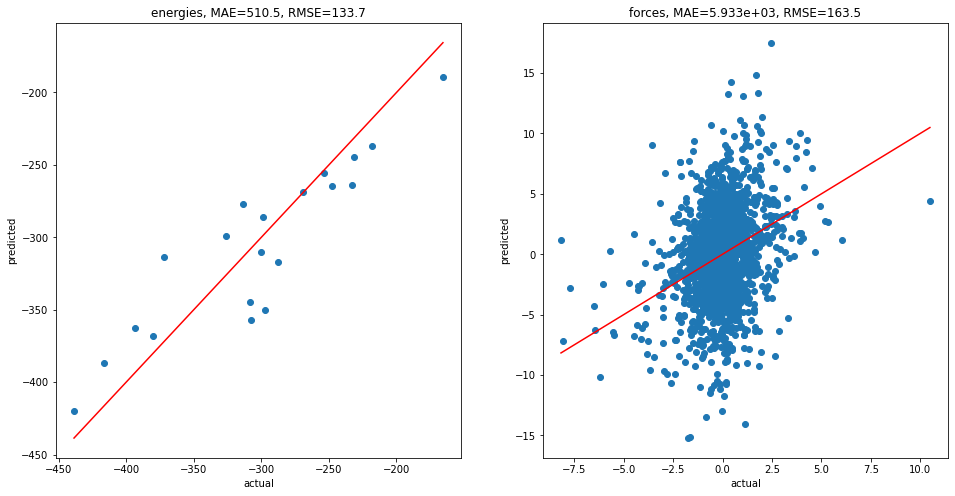

In [27]:
fig = parity_plots(*evaluate_model_with_forces(model, test_dataloader_grad))

In [28]:
def check_finite_differences(model, frame, delta=1e-6):
    frame = frame.copy()
    delta_frame = frame.copy()
    delta_frame.positions[3, 1] += delta

    dataset = AtomisticDataset(
        [frame, delta_frame], 
        all_species, 
        {"radial_spectrum": HYPERS_RAD_GRAD, "spherical_expansion":HYPERS_GRAD}, 
        torch.zeros(2, 1), 
    )
    dataloader = create_dataloader(
        dataset,
        batch_size=len(dataset),
        shuffle=False,
        device=device,
    )

    for frame, radial_spectrum, spherical_expansions, _, _ in dataloader:
        predicted_e, predicted_f = model(frame, radial_spectrum, spherical_expansions, forward_forces=True)

    finite_diff = - (predicted_e[1] - predicted_e[0]) / delta
    print("finite difference =", finite_diff.item())
    print("computed gradient =", predicted_f[3, 1].item())

In [29]:
if torch.get_default_dtype() == torch.float64:
    delta = 1e-6
else:
    delta = 1e-3

check_finite_differences(model, train_frames[22], delta)

finite difference = 3.07691419720868
computed gradient = 3.076920083417521
